# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon

This notebook presents a complete pipeline to solve the **Bike Sharing Demand** prediction problem using [AutoGluon](https://auto.gluon.ai/), an AutoML library built by AWS.

The goal is to accurately predict the number of bike rentals per hour based on datetime, weather, and seasonal data. The project follows a structured workflow including:

- Data exploration and preprocessing  
- Feature engineering to improve model signals  
- Model training using AutoGluon's `TabularPredictor`  
- Hyperparameter tuning to improve performance  
- Submission of predictions to the Kaggle competition

This notebook achieved a final **RMSLE score of 0.45** on the public leaderboard.

---

## Download the Kaggle dataset using the kaggle python library

### Install packages

In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

ERROR: To modify pip, please run the following command:
C:\Users\janaa\AppData\Local\Programs\Python\Python312\python.exe -m pip install -U pip

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached pip-25.1.1-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-25.1.1-py3-none-any.whl (1.8 MB)



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached mxnet-1.7.0.post2-py2.py3-none-win_amd64.whl.metadata (402 bytes)
  Using cached bokeh-2.0.1.tar.gz (8.6 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [21 lines of output]
      C:\Users\janaa\AppData\Local\Temp\pip-install-hr1in7w3\bokeh_ce17a74c24de451d854c6fc827d76c4b\versioneer.py:416: SyntaxWarning: invalid escape sequence '\s'
        LONG_VERSION_PY['git'] = '''
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\janaa\AppData\Local\Temp\pip-install-hr1in7w3\bokeh_ce17a74c24de451d854c6fc827d76c4b\setup.py", line 118, in <module>
          version=get_version(),
                  ^^^^^^^^^^^^^
        File "C:\Users\janaa\AppData\Local\Temp\pip-install-hr1in7w3\bokeh_ce17a74c24de451d854c6fc827d76c4b\_setup_support.py", line 243, in get_version
          return versioneer.get_version()
                 ^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\janaa\AppData\Local\Temp\pip-install-hr1in7w3\b


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Download and explore dataset

In [10]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [4]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv", parse_dates=["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe().T

,count,mean,min,25%,50%,75%,max,std
datetime,10886,2011-12-27 05:56:22.399411968,2011-01-01 00:00:00,2011-07-02 07:15:00,2012-01-01 20:30:00,2012-07-01 12:45:00,2012-12-19 23:00:00,NaN
season,10886.0,2.506614,1.0,2.0,3.0,4.0,4.0,1.116174
holiday,10886.0,0.028569,0.0,0.0,0.0,0.0,1.0,0.166599
workingday,10886.0,0.680875,0.0,0.0,1.0,1.0,1.0,0.466159
weather,10886.0,1.418427,1.0,1.0,1.0,2.0,4.0,0.633839
temp,10886.0,20.23086,0.82,13.94,20.5,26.24,41.0,7.79159
atemp,10886.0,23.655084,0.76,16.665,24.24,31.06,45.455,8.474601
humidity,10886.0,61.88646,0.0,47.0,62.0,77.0,100.0,19.245033
windspeed,10886.0,12.799395,0.0,7.0015,12.998,16.9979,56.9969,8.164537
casual,10886.0,36.021955,0.0,4.0,17.0,49.0,367.0,49.960477


In [15]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv",parse_dates=["datetime"])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [21]:
# Same thing as train and test dataset
submission = submission = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [62]:
predictor = TabularPredictor(
    label="count",
    eval_metric="root_mean_squared_error",
    learner_kwargs={"ignored_columns": ["casual", "registered"]},
).fit(train_data=train, time_limit=600, presets="best_quality")


No path specified. Models will be saved in: "AutogluonModels\ag-20250629_025542"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       3.45 GB / 15.73 GB (22.0%)
Disk Space Avail:   15.46 GB / 200.00 GB (7.7%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout 

### Review AutoGluon's training run with ranking of models that did the best.

In [12]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -50.833926  root_mean_squared_error       7.874560  286.894867                0.000000           0.061218            3       True         19
1   NeuralNetFastAI_BAG_L2  -52.060552  root_mean_squared_error       6.837717  269.314152                0.332342          29.805194            2       True         17
2   RandomForestMSE_BAG_L2  -53.248019  root_mean_squared_error       7.058429  253.542089                0.553054          14.033131            2       True         14
3     ExtraTreesMSE_BAG_L2  -53.855883  root_mean_squared_error       6.989164  242.995323                0.483789           3.486366            2       True         16
4          LightGBM_BAG_L2  -54.734365  root_mean_squared_error       6.777781  244.271646   

c:\Users\janaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleMode

### Create predictions from test dataset

In [16]:
predictions = predictor.predict(test)
predictions.head()

0    24.109631
1    39.593227
2    44.549683
3    47.107903
4    49.499741
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [17]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      101.012245
std        88.462227
min         1.259169
25%        23.212559
50%        66.849815
75%       170.391006
max       350.556274
Name: count, dtype: float64

In [18]:
# How many negative values do we have?
predictions.loc[predictions<0]

Series([], Name: count, dtype: float32)

In [19]:
# Set them to zero
predictions.loc[predictions<0]=0

### Set predictions to submission dataframe, save, and submit

In [22]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [28]:
import os

# نعيّن بيانات الحساب يدوياً من ملف kaggle.json
os.environ['KAGGLE_USERNAME'] = "janaabdullh"
os.environ['KAGGLE_KEY'] = "438ea17f3cc37fae4b3b957b89876eaa"


In [29]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/195k [00:00<?, ?B/s]
  8%|▊         | 16.0k/195k [00:00<00:02, 69.7kB/s]
 58%|█████▊    | 112k/195k [00:00<00:00, 304kB/s]  
 99%|█████████▊| 192k/195k [00:00<00:00, 429kB/s]
100%|██████████| 195k/195k [00:01<00:00, 176kB/s]


#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [30]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

'tail' is not recognized as an internal or external command,
operable program or batch file.


In [31]:
!kaggle competitions submissions -c bike-sharing-demand


fileName        date                        description           status                     publicScore  privateScore  
--------------  --------------------------  --------------------  -------------------------  -----------  ------------  
submission.csv  2025-06-28 01:02:08.860000  first raw submission  SubmissionStatus.COMPLETE  1.77836      1.77836       


#### Initial score of 1.77836

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'holiday'}>],
       [<Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'weather'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>]], dtype=object)

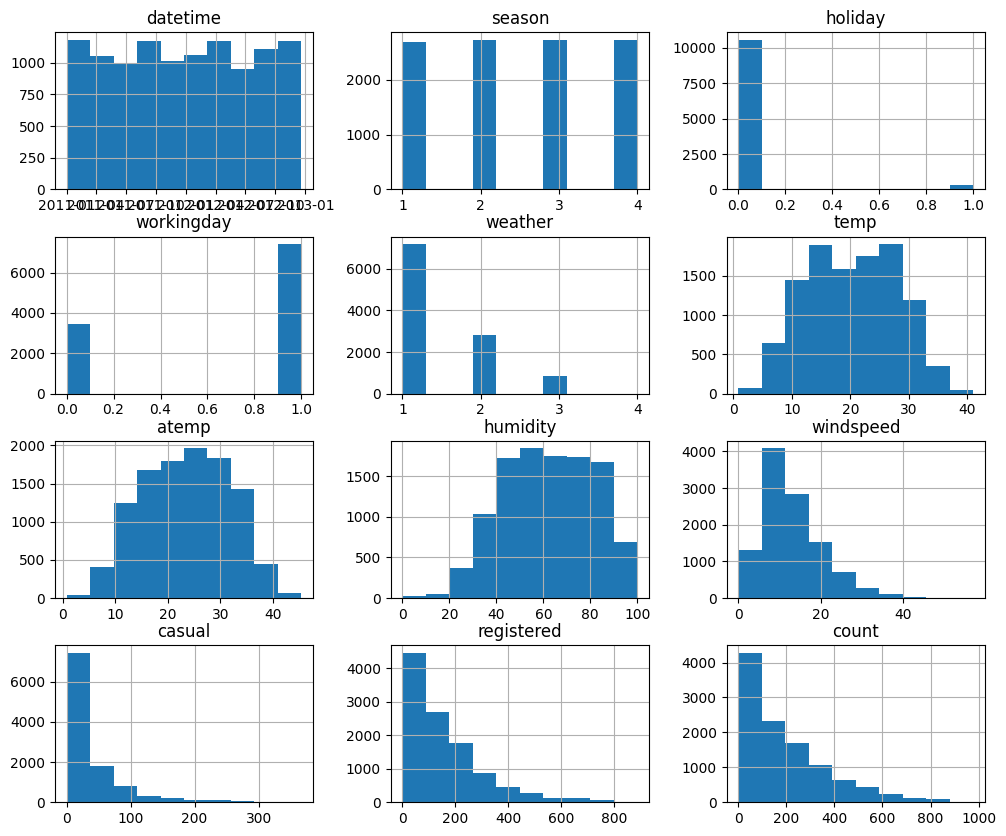

In [35]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(12,10))

In [36]:
# create a new feature
train["hour"] = train.datetime.dt.hour
test["hour"] = test.datetime.dt.hour

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [37]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [38]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>],
       [<Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>],
       [<Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>],
       [<Axes: title={'center': 'count'}>,
        <Axes: title={'center': 'hour'}>, <Axes: >]], dtype=object)

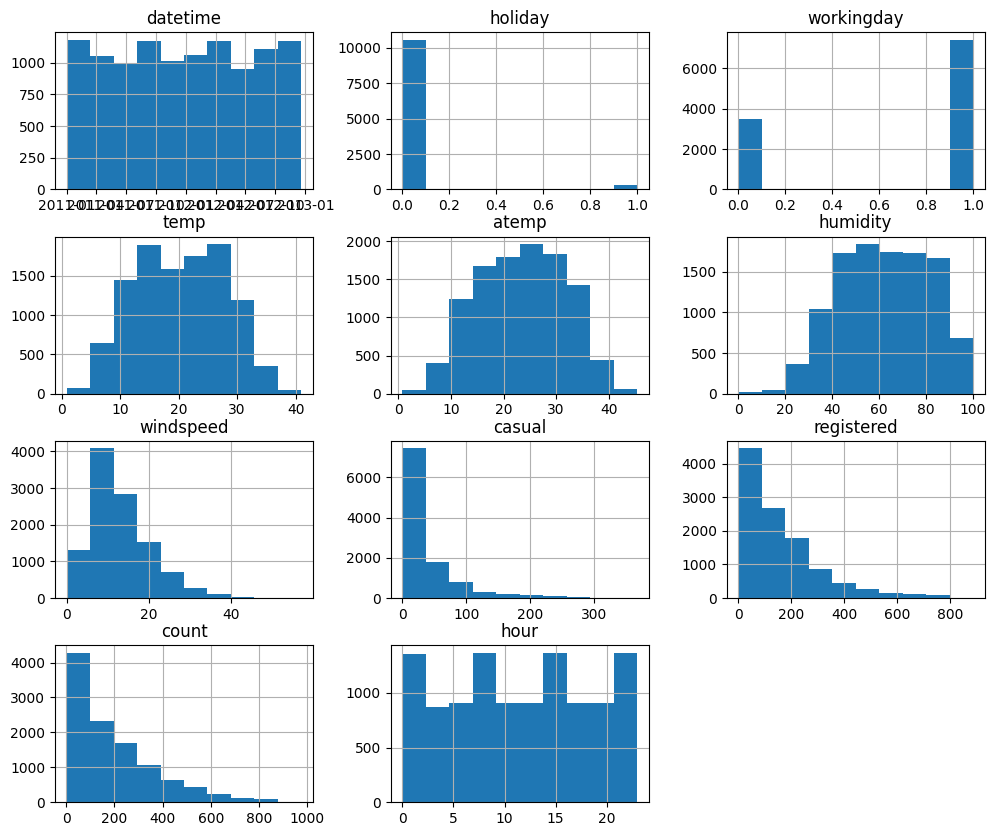

In [39]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(12,10))

## Step 5: Rerun the model with the same settings as before, just with more features

In [40]:
predictor_new_features = TabularPredictor(
    label="count",
    eval_metric="root_mean_squared_error",
    learner_kwargs={"ignored_columns": ["casual", "registered"]},
).fit(train_data=train, time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels\ag-20250628_020217"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       4.72 GB / 15.73 GB (30.0%)
Disk Space Avail:   30.98 GB / 200.00 GB (15.5%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout

In [41]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.069406  root_mean_squared_error      10.620036  366.285974                0.000000           0.066508            3       True         16
1          CatBoost_BAG_L2  -30.329903  root_mean_squared_error       9.259026  334.916734                0.092499          76.469315            2       True         13
2          LightGBM_BAG_L2  -30.555652  root_mean_squared_error       9.442873  262.680252                0.276346           4.232832            2       True         11
3        LightGBMXT_BAG_L2  -31.211229  root_mean_squared_error       9.873233  272.567842                0.706706          14.120422            2       True         10
4     ExtraTreesMSE_BAG_L2  -31.392221  root_mean_squared_error       9.655037  261.901572   

c:\Users\janaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': np.float64(-101.58817625927213),
  'KNeighborsDist_BAG_L1': np.flo

In [43]:
# Remember to set all negative values to zero
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features.loc[predictions_new_features < 0] = 0

In [44]:
# Same submitting predictions
submission_new_features=pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [45]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/194k [00:00<?, ?B/s]
  8%|▊         | 16.0k/194k [00:00<00:02, 77.7kB/s]
 58%|█████▊    | 112k/194k [00:00<00:00, 351kB/s]  
100%|██████████| 194k/194k [00:00<00:00, 480kB/s]
100%|██████████| 194k/194k [00:01<00:00, 188kB/s]


In [47]:
!kaggle competitions submissions -c bike-sharing-demand

fileName                     date                        description           status                     publicScore  privateScore  
---------------------------  --------------------------  --------------------  -------------------------  -----------  ------------  
submission_new_features.csv  2025-06-29 01:53:15.603000  new features          SubmissionStatus.COMPLETE  0.70223      0.70223       
submission.csv               2025-06-28 01:02:08.860000  first raw submission  SubmissionStatus.COMPLETE  1.77836      1.77836       


#### New Score of 0.70

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [49]:
predictor_new_hpo = TabularPredictor(
    label="count",
    eval_metric="root_mean_squared_error",
    learner_kwargs={"ignored_columns": ["casual", "registered"]},
).fit(
    train_data=train,
    time_limit=1800,
    num_bag_folds=5,
    num_stack_levels=2,
    excluded_model_types=["KNN"],
    presets="best_quality",
)

No path specified. Models will be saved in: "AutogluonModels\ag-20250629_021215"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       3.43 GB / 15.73 GB (21.8%)
Disk Space Avail:   22.97 GB / 200.00 GB (11.5%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=2, num_bag_folds=5, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout

In [50]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val              eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L4 -31.800732  root_mean_squared_error      10.716520   807.192798                0.000000           0.048940            4       True         40
1           WeightedEnsemble_L3 -31.800732  root_mean_squared_error      10.716520   807.193675                0.000000           0.049817            3       True         28
2           WeightedEnsemble_L2 -32.086109  root_mean_squared_error       8.311301   542.994060                0.000000           0.022751            2       True         10
3          ExtraTreesMSE_BAG_L2 -32.189846  root_mean_squared_error       9.519913   569.432231                0.483338           3.247082            2       True         15
4            CatBoost_r9_BAG_L2 -32.203542  root_mean_squared_error 

c:\Users\janaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L2': 'StackerEnsembleM

In [52]:
# Remember to set all negative values to zero
predictions_new_hpo = predictor_new_hpo.predict(test)
predictions_new_hpo.loc[predictions_new_hpo < 0] = 0

In [55]:
# Same submitting predictions
submission_new_hpo = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [56]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/194k [00:00<?, ?B/s]
  8%|▊         | 16.0k/194k [00:00<00:02, 64.5kB/s]
 49%|████▉     | 96.0k/194k [00:00<00:00, 331kB/s] 
 74%|███████▍  | 144k/194k [00:00<00:00, 270kB/s] 
100%|██████████| 194k/194k [00:01<00:00, 172kB/s]


In [58]:
!kaggle competitions submissions -c bike-sharing-demand


fileName                     date                        description                        status                     publicScore  privateScore  
---------------------------  --------------------------  ---------------------------------  -------------------------  -----------  ------------  
submission_new_hpo.csv       2025-06-29 02:44:47.353000  new features with hyperparameters  SubmissionStatus.COMPLETE  0.45444      0.45444       
submission_new_features.csv  2025-06-29 01:53:15.603000  new features                       SubmissionStatus.COMPLETE  0.70223      0.70223       
submission.csv               2025-06-28 01:02:08.860000  first raw submission               SubmissionStatus.COMPLETE  1.77836      1.77836       


#### New Score of 0.45

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

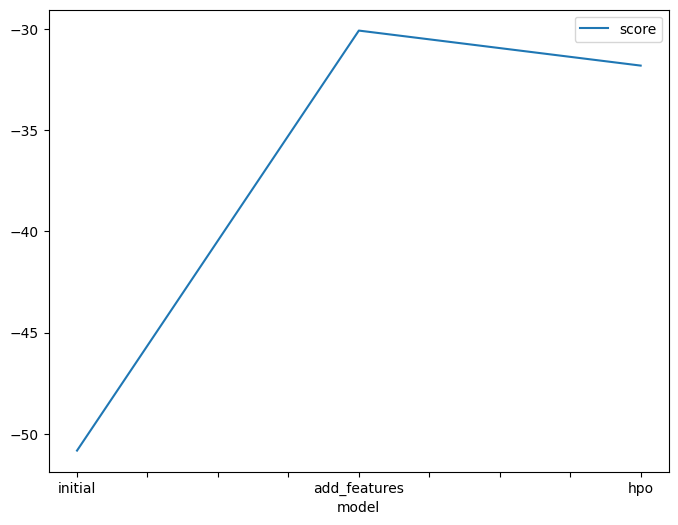

In [59]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [
            predictor.leaderboard(silent=True)['score_val'][0],
            predictor_new_features.leaderboard(silent=True)['score_val'][0],
            predictor_new_hpo.leaderboard(silent=True)['score_val'][0] ]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

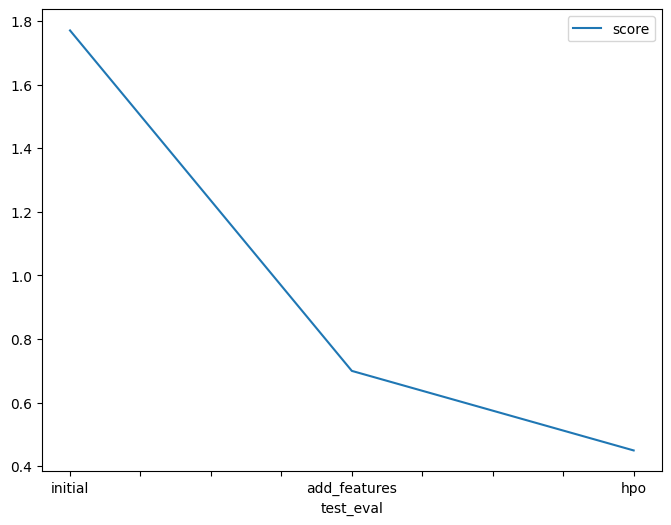

In [60]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.77, 0.7, 0.45]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [61]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "time": [600, 600, 1800],
    "num_bag_folds": [10, 10, 5],
    "num_stack_levels": [3, 3, 2],
    "score": [1.77, 0.70, 0.45]
})

,model,time,num_bag_folds,num_stack_levels,score
0,initial,600,10,3,1.77
1,add_features,600,10,3,0.70
2,hpo,1800,5,2,0.45
